We are writing this notebook as first scratch of smoothing stuff to do double cropping classification.

This notebook will eventually be running on Colab. And hopefully we can maitain a .py script in sublime editor.

# import libraries

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import sys
from IPython.display import Image
from shapely.geometry import Point, Polygon
from math import factorial
import datetime
import time
import scipy

from statsmodels.sandbox.regression.predstd import wls_prediction_std
from sklearn.linear_model import LinearRegression
from patsy import cr

from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sb

## Define Functions

In [2]:
def filter_out_unwanted(dt_df):
    unwanted_plants = ["Almond", "Apple", "Alfalfa/Grass Hay",
                       "Apricot", "Asparagus", "Berry, Unknown",  
                       "Blueberry", "Cherry", "Grape, Juice", 
                       "Grape, Table", "Grape, Unknown", 
                       "Grape, Wine", "Hops", "Mint", 
                       "Nectarine/Peach", "Orchard, Unknown", 
                       "Pear", "Plum", "Strawberry", "Walnut"]
    
    # filter unwanted plants
    dt_df = dt_df[~(dt_df['CropTyp'].isin(unwanted_plants))]
    
    # filter non-irrigated
    """
    # These two lines can replace the following two lines
    non_irrigations = ["Unknown", "None", "None/Rill", "None/Sprinkler", 
                       "None/Sprinkler/Wheel Line", 
                       "None/Wheel Line", "Drip/None", "Center Pivot/None"]
    
    dt_df = dt_df[~(dt_df['Irrigtn'].isin(non_irrigations))]
    """
    dt_df = dt_df[~dt_df['Irrigtn'].str.contains("None")]
    dt_df = dt_df[~dt_df['Irrigtn'].str.contains("Unknown")]
    
    return dt_df
    
def initial_clean(dt):
    # remove the useles system:index column
    if ("system:index" in list(grant_2018.columns)):
        dt = dt.drop(columns=['system:index'])
    
    # Drop rows whith NA in NDVI column.
    dt = dt[dt['NDVI'].notna()]
    
    # rename the column .geo to "geo"
    dt = dt.rename(columns={".geo": "geo"})
    
    # clean non-irrigated and perrinials
    dt = filter_out_unwanted(dt)
    return (dt)

def short_polygon_ID(dt):
    return (dt)

def order_by_doy(dt):
    return dt.sort_values(by='doy', axis=0, ascending=True)


def savitzky_golay(y, window_size, order, deriv=0, rate=1):
    """
    Smooth (and optionally differentiate) data with a Savitzky-Golay filter.
    The Savitzky-Golay filter removes high frequency noise from data.
    It has the advantage of preserving the original shape and
    features of the signal better than other types of filtering
    approaches, such as moving averages techniques.
    Parameters
    ----------
    y : array_like, shape (N,)
        the values of the time history of the signal.
    window_size : int
        the length of the window. Must be an odd integer number.
    order : int
        the order of the polynomial used in the filtering.
        Must be less then `window_size` - 1.
    deriv: int
        the order of the derivative to compute (default = 0 means only smoothing)
    Returns
    -------
    ys : ndarray, shape (N)
        the smoothed signal (or it's n-th derivative).
    Notes
    -----
    The Savitzky-Golay is a type of low-pass filter, particularly
    suited for smoothing noisy data. The main idea behind this
    approach is to make for each point a least-square fit with a
    polynomial of high order over a odd-sized window centered at
    the point.
    Examples
    --------
    t = np.linspace(-4, 4, 500)
    y = np.exp( -t**2 ) + np.random.normal(0, 0.05, t.shape)
    ysg = savitzky_golay(y, window_size=31, order=4)
    import matplotlib.pyplot as plt
    plt.plot(t, y, label='Noisy signal')
    plt.plot(t, np.exp(-t**2), 'k', lw=1.5, label='Original signal')
    plt.plot(t, ysg, 'r', label='Filtered signal')
    plt.legend()
    plt.show()
    References
    ----------
    .. [1] A. Savitzky, M. J. E. Golay, Smoothing and Differentiation of
       Data by Simplified Least Squares Procedures. Analytical
       Chemistry, 1964, 36 (8), pp 1627-1639.
    .. [2] Numerical Recipes 3rd Edition: The Art of Scientific Computing
       W.H. Press, S.A. Teukolsky, W.T. Vetterling, B.P. Flannery
       Cambridge University Press ISBN-13: 9780521880688
    """

    try:
        window_size = np.abs(np.int(window_size))
        order = np.abs(np.int(order))
    except ValueError:
        raise ValueError("window_size and order have to be of type int")
    if window_size % 2 != 1 or window_size < 1:
        raise TypeError("window_size size must be a positive odd number")
    if window_size < order + 2:
        raise TypeError("window_size is too small for the polynomials order")
    order_range = range(order+1)
    half_window = (window_size -1) // 2
    
    y_array = np.array(y)
    # precompute coefficients
    b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = y_array[0] - np.abs( y_array[1:half_window+1][::-1] - y_array[0] )
    lastvals = y_array[-1] + np.abs(y_array[-half_window-1:-1][::-1] - y_array[-1])
    y_array = np.concatenate((firstvals, y_array, lastvals))
    return np.convolve( m[::-1], y_array, mode='valid')


def _datacheck_peakdetect(x_axis, y_axis):
    if x_axis is None:
        x_axis = range(len(y_axis))
    
    if len(y_axis) != len(x_axis):
        raise (ValueError, 
                'Input vectors y_axis and x_axis must have same length')
    
    #needs to be a numpy array
    y_axis = np.array(y_axis)
    x_axis = np.array(x_axis)
    return x_axis, y_axis

def peakdetect(y_axis, x_axis = None, lookahead = 300, delta=0):
    """
    Converted from/based on a MATLAB script at: 
    http://billauer.co.il/peakdet.html
    
    https://github.com/mattijn/pynotebook/blob/16fe0f58624938b82d93cbd208b8cb871ab95ec1/
    ipynotebooks/Python2.7/.ipynb_checkpoints/PLOTS%20SIGNAL%20PROCESSING-P1%20and%20P2-checkpoint.ipynb
     
    also look at: https://gist.github.com/endolith/250860
    and 
    http://billauer.co.il/peakdet.html
    
    
    
    function for detecting local maximas and minmias in a signal.
    Discovers peaks by searching for values which are surrounded by lower
    or larger values for maximas and minimas respectively
    
    keyword arguments:
    y_axis -- A list containg the signal over which to find peaks
    x_axis -- (optional) A x-axis whose values correspond to the y_axis list
        and is used in the return to specify the postion of the peaks. If
        omitted an index of the y_axis is used. (default: None)
    lookahead -- (optional) distance to look ahead from a peak candidate to
        determine if it is the actual peak (default: 200) 
        '(sample / period) / f' where '4 >= f >= 1.25' might be a good value
    delta -- (optional) this specifies a minimum difference between a peak and
        the following points, before a peak may be considered a peak. Useful
        to hinder the function from picking up false peaks towards to end of
        the signal. To work well delta should be set to delta >= RMSnoise * 5.
        (default: 0)
            delta function causes a 20% decrease in speed, when omitted
            Correctly used it can double the speed of the function
    
    return -- two lists [max_peaks, min_peaks] containing the positive and
        negative peaks respectively. Each cell of the lists contains a tupple
        of: (position, peak_value) 
        to get the average peak value do: np.mean(max_peaks, 0)[1] on the
        results to unpack one of the lists into x, y coordinates do: 
        x, y = zip(*tab)
    """
    max_peaks = []
    min_peaks = []
    dump = []   #Used to pop the first hit which almost always is false
       
    # check input data
    x_axis, y_axis = _datacheck_peakdetect(x_axis, y_axis)
    # store data length for later use
    length = len(y_axis)
    
    
    #perform some checks
    if lookahead < 1:
        raise ValueError ( "Lookahead must be '1' or above in value")
    if not (np.isscalar(delta) and delta >= 0):
        raise ValueError ( "delta must be a positive number" )
    
    #maxima and minima candidates are temporarily stored in
    #mx and mn respectively
    mn, mx = np.Inf, -np.Inf
    
    #Only detect peak if there is 'lookahead' amount of points after it
    for index, (x, y) in enumerate(zip(x_axis[:-lookahead], 
                                        y_axis[:-lookahead])):
        if y > mx:
            mx = y
            mxpos = x
        if y < mn:
            mn = y
            mnpos = x
        
        ####look for max####
        if y < mx-delta and mx != np.Inf:
            #Maxima peak candidate found
            #look ahead in signal to ensure that this is a peak and not jitter
            if y_axis[index:index+lookahead].max() < mx:
                max_peaks.append([mxpos, mx])
                dump.append(True)
                #set algorithm to only find minima now
                mx = np.Inf
                mn = np.Inf
                if index+lookahead >= length:
                    #end is within lookahead no more peaks can be found
                    break
                continue
            #else:  #slows shit down this does
            #    mx = ahead
            #    mxpos = x_axis[np.where(y_axis[index:index+lookahead]==mx)]
        
        ####look for min####
        if y > mn+delta and mn != -np.Inf:
            #Minima peak candidate found 
            #look ahead in signal to ensure that this is a peak and not jitter
            if y_axis[index:index+lookahead].min() > mn:
                min_peaks.append([mnpos, mn])
                dump.append(False)
                #set algorithm to only find maxima now
                mn = -np.Inf
                mx = -np.Inf
                if index+lookahead >= length:
                    #end is within lookahead no more peaks can be found
                    break
            #else:  #slows shit down this does
            #    mn = ahead
            #    mnpos = x_axis[np.where(y_axis[index:index+lookahead]==mn)]
    
    
    #Remove the false hit on the first value of the y_axis
    try:
        if dump[0]:
            max_peaks.pop(0)
        else:
            min_peaks.pop(0)
        del dump
    except IndexError:
        # no peaks were found, should the function return empty lists?
        pass
        
    return [max_peaks, min_peaks]

def form_xs_ys_from_peakdetect(max_peak_list, doy_vect):
    dd = np.array(doy_vect)
    xs = np.zeros(len(max_peak_list))
    ys = np.zeros(len(max_peak_list))
    for ii in range(len(max_peak_list)):  
        xs[ii] = dd[int(max_peak_list[ii][0])]
        ys[ii] = max_peak_list[ii][1]
    return (xs, ys)

# Extensive peak detect

## Define directories
Here we can define data or core.py directories

In [4]:
data_dir = "/Users/hn/Documents/01_research_data/Ag_check_point/remote_sensing/01_NDVI_TS/Grant/"

## Define some parameters

In [5]:
file_names = ["Grant_2018_TS.csv"]

## Read Data

In [6]:
file_N = file_names[0]
grant_2018 = pd.read_csv(data_dir + file_N)

In [7]:
print ("The data before cleaning is of size", str(grant_2018.shape))
grant_2018 = initial_clean(grant_2018)
print ("The data after cleaning is of size", str(grant_2018.shape))

The data before cleaning is of size (385, 24)
The data after cleaning is of size (378, 23)


In [8]:
# Count distict values, use nunique:
pprint (grant_2018['geo'].nunique())

# Count only non-null values, use count:
print (grant_2018['geo'].count())

# Count total values including null values, use size attribute:
print (grant_2018['geo'].size)

7
378
378


#### List of unique polygons

In [9]:
polygon_list = grant_2018['geo'].unique()

# Pick one of the polygons and test the smoothing methods

In [10]:
grant_2018_first_field = grant_2018[grant_2018['geo']==polygon_list[1]]
grant_2018_first_field = order_by_doy(grant_2018_first_field)
print(grant_2018_first_field.shape)
print(type(grant_2018_first_field))
grant_2018_first_field.head(2)

(54, 23)
<class 'pandas.core.frame.DataFrame'>


,Acres,B2,B3,B4,B8,CovrCrp,CropGrp,CropTyp,DataSrc,ExctAcr,...,NDVI,Notes,RtCrpTy,Shap_Ar,Shp_Lng,TRS,county,doy,year,geo
55,12,0.448152,0.408292,0.461851,0.442636,NaN,Cereal Grain,Wheat Fallow,NASS,11.921425,...,-0.022229,NaN,CRP/Conservation,48244.295189,1137.363017,T24R26E36,Grant,2.0,2018.0,"{""type"":""Polygon"",""coordinates"":[[[-119.511854..."
56,12,0.322719,0.281231,0.310058,0.305632,NaN,Cereal Grain,Wheat Fallow,NASS,11.921425,...,-0.005791,NaN,CRP/Conservation,48244.295189,1137.363017,T24R26E36,Grant,29.0,2018.0,"{""type"":""Polygon"",""coordinates"":[[[-119.511854..."


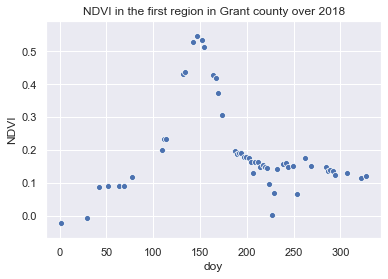

In [11]:
# ax = plt.gca()
# grant_2018_first_field.plot(kind='line',x='doy',y='NDVI',ax=ax)
# plt.show();
sb.set();
plot = sb.scatterplot(x="doy", y="NDVI", data=grant_2018_first_field)
plot = plot.set(title = 'NDVI in the first region in Grant county over 2018');

In [12]:
X = grant_2018_first_field['doy']
y = grant_2018_first_field['NDVI']

### 1.  Weighted Least Square

In [ ]:
# print(res_wls.summary())

### Locally weighted regression
   - The [documentation page](https://www.statsmodels.org/stable/generated/statsmodels.nonparametric.smoothers_lowess.lowess.html) from stats model package
   
In the following the parameters are:

   - `frac`:  Between 0 and 1. The fraction of the data used when estimating each y-value.
   - `itint`: The number of residual-based reweightings to perform.

In [ ]:
lowess = sm.nonparametric.lowess
LWLS_1 = lowess(endog=y, exog=X, frac= 1./3, it=0)
LWLS_2 = lowess(endog=y, exog=X, frac= 1./3)
LWLS_3 = lowess(endog=y, exog=X, frac= 1./3, it=5)
# predict_3 = lowess(endog=y, exog=X)

In [ ]:
fig, ax = plt.subplots(figsize=(8,6));
ax.plot(X, y, 'o', label="Data");

ax.plot(X, LWLS_1[:, 1], 'g--.', label="predict_1")
ax.plot(X, LWLS_2[:, 1], 'r--.', label="predict_2")
ax.plot(X, LWLS_3[:, 1], 'b--.', label="predict_3")
ax.legend(loc="best");

## Savitzky Golay filtering

In [ ]:
smoothed_by_Savitzky = savitzky_golay(y, window_size=5, order=1)
fig, ax = plt.subplots(figsize=(8,6));
ax.plot(X, y, 'o', label="Data");

ax.plot(X, LWLS_1[:, 1], 'g--.', label="predict_1 by LWLS")
ax.plot(X, LWLS_2[:, 1], 'r--.', label="predict_2 by LWLS")
ax.plot(X, LWLS_3[:, 1], 'b--.', label="predict_3 by LWLS")
ax.plot(X, smoothed_by_Savitzky, 'k--.', label="smoothed_by_Savitzky")
ax.legend(loc="best");

## Gaussian Filtering/convolution 
[Documentation page](https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.gaussian_filter.html)

In [ ]:
gaussian_smoothed = scipy.ndimage.gaussian_filter(input=y, sigma=2.5, order=0)

In [ ]:
fig, ax = plt.subplots(figsize=(8,6));
ax.plot(X, y, 'o', label="Data");

ax.plot(X, LWLS_1[:, 1], 'g--.', label="predict_1 by LWLS")
ax.plot(X, LWLS_3[:, 1], 'b--.', label="predict_3 by LWLS")
ax.plot(X, smoothed_by_Savitzky, 'k--.', label="Savitzky")
ax.plot(X, gaussian_smoothed, 'r--.', label="Gaussian")
ax.legend(loc="best");

## Spline Smooothing

In [ ]:
freedom_df = 7

# Generate spline basis with 10 degrees of freedom
x_basis = cr(X, df=freedom_df, constraints='center')

# Fit model to the data
model = LinearRegression().fit(x_basis, y)

# Get estimates
y_hat = model.predict(x_basis)


#### Plot smoothing spline result

In [ ]:
plt.scatter(X, y, s=7)
plt.plot(X, y_hat, 'r', label="smoothing spline result");
plt.title(f'Natural cubic spline with {freedom_df} degrees of freedom')

In [ ]:
# find peaks
peaks = peakdetect(LWLS_1[:, 1], lookahead = 10, delta=0)
max_peaks = peaks[0]
peaks = form_xs_ys_from_peakdetect(max_peak_list = max_peaks, doy_vect=X)

### Plot peaks

In [ ]:
plt.scatter(X, y, s=7);
plt.scatter(peaks[0], peaks[1], s=100, c='g', marker='*');
plt.plot(X, y_hat, 'r');
plt.title(f'Natural cubic spline with {freedom_df} degrees of freedom \n and peak point in red');

In [ ]:
# ax = plt.gca()
# grant_2018_first_field.plot(kind='line',x='doy',y='NDVI',ax=ax)
# plt.show();
sb.set();
plot = sb.scatterplot(x="doy", y="NDVI", data=grant_2018_first_field)
plot = plot.plot(X, y_hat, 'r', label="smoothing spline result");
# plot = plot.set(title = 'NDVI in the first region in Grant county over 2018');

In [ ]:
import numpy as np
from scipy.optimize import curve_fit
import pylab

x0, A, gamma = 12, 3, 5

n = 200
x = np.linspace(1, 20, n)
yexact = A * gamma**2 / (gamma**2 + (x-x0)**2)

# Add some noise with a sigma of 0.5 apart from a particularly noisy region
# near x0 where sigma is 3
sigma = np.ones(n)*0.5
sigma[np.abs(x-x0+1)<1] = 3
noise = np.random.randn(n) * sigma
y = yexact + noise

def f(x, x0, A, gamma):
    """ The Lorentzian entered at x0 with amplitude A and HWHM gamma. """
    return A *gamma**2 / (gamma**2 + (x-x0)**2)

def rms(y, yfit):
    return np.sqrt(np.sum((y-yfit)**2))

# Unweighted fit
p0 = 10, 4, 2
popt, pcov = curve_fit(f, x, y, p0)
yfit = f(x, *popt)
print('Unweighted fit parameters:', popt)
print('Covariance matrix:'); print(pcov)
print('rms error in fit:', rms(yexact, yfit))
print()

# Weighted fit
popt2, pcov2 = curve_fit(f, x, y, p0, sigma=sigma, absolute_sigma=True)
yfit2 = f(x, *popt2)
print('Weighted fit parameters:', popt2)
print('Covariance matrix:'); print(pcov2)
print('rms error in fit:', rms(yexact, yfit2))

pylab.plot(x, yexact, label='Exact')
pylab.plot(x, y, 'o', label='Noisy data')
pylab.plot(x, yfit, label='Unweighted fit')
pylab.plot(x, yfit2, label='Weighted fit')
pylab.ylim(-1,4)
pylab.legend(loc='best')
pylab.show()

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sb
import statsmodels.api as sm
%matplotlib inline
# generate random data
np.random.seed(24)
x = np.random.uniform(-5,5,25)
ϵ = 2*np.random.randn(25)
y = 2*x+ϵ

# alternate error as a function of x
ϵ2 = ϵ*(x+5)
y2 = 2*x+ϵ2
sns.regplot(x,y);
sns.regplot(x,y2);


# add a strong outlier for high x
x_high = np.append(x,5)
y_high = np.append(y2,160)
# add a strong outlier for low x
x_low = np.append(x,-4)
y_low = np.append(y2,160) 

In [ ]:
# reshape for compatibility
X_low = x_low.reshape(-1, 1)
X_high = x_high.reshape(-1, 1)

# calculate weights for sets with low and high outlier
sample_weights_low = [1/(x+5) for x in x_low]
sample_weights_high = [1/(x+5) for x in x_high] 

# ---------


# import and fit an OLS model, check coefficients
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_low, y_low)
# fit WLS using sample_weights
WLS = LinearRegression()
WLS.fit(X_low, y_low, sample_weight=sample_weights_low)
print(model.intercept_, model.coef_)
print('WLS')
print(WLS.intercept_, WLS.coef_)
# run this yourself, don't trust every result you see online =)

In [ ]:
#
# double logistic 
#
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.optimize import minimize

import ad


def double_logistic_array(params,timeArr):
    phenology=[]
    for time in timeArr:
        phenology.append(double_logistic(params,time))
    return np.array(phenology)

def double_logistic(params,time):
    """Generate a double logistic curve similar 
    to those of the MODIS phenology product
    
    k1   --- curvature parmeter for first half of season
    k2   --- curvature parmeter for second half of season
    t01  --- timing parmeter for first half of season
    t02  --- timing parmeter for second half of season
    c    --- minimum LAI/NDVI etc
    d    --- maximum LAI/NDVI etc
    
    time --- time valueto evaluate the function 
    """
    k1  =params[0]
    k2  =params[1]
    t01 =params[2]
    t02 =params[3]
    c   =params[4]
    d   =params[5]
    lgstc1=(c-d)/(1.+math.exp(k1*(time-t01)))+d    
    lgstc2=(d-c)/(1.+math.exp(k2*(time-t02)))+c
    return np.min([lgstc1,lgstc2])
    
def genSynthObs(params,freq=10,stddev=0.3,cloud=0.0):
    
    time_arr=[]
    synth_obs=[]
    for t in range(0,366,freq):
        if np.random.rand()<cloud:
            continue
        time_arr.append(t)
        obs=double_logistic(params,t)
        obs=obs+np.random.normal(0.,stddev)
        synth_obs.append(obs)
        
    return np.array(synth_obs),np.array(time_arr)


def rmse(params,obs,obs_time):
    model=double_logistic_array(params,obs_time)
    return np.sqrt(np.sum((model-obs)**2)/float(len(obs_time)))
    
def solver(params,obs,obs_time,costFunction):
    costGradient, costHessian=ad.gh(costFunction)
    return minimize(costFunction,\
                    params,\
                    args=(obs,obs_time),\
                    method='L-BFGS-B',\
                    jac=costGradient,\
                    options={'gtol': 1e-10})
    
    
    
if __name__=="__main__":

    time_arr=np.arange(366)
    
    params=np.zeros(6)
    params[0]=0.1
    params[1]=0.5
    params[2]=100
    params[3]=290
    params[4]=0.1
    params[5]=2.5
    
    phenology=double_logistic_array(params,time_arr)
    synth_obs, obs_times=genSynthObs(params,freq=10,stddev=0.25,cloud=0.5)
      
    s=solver(params,synth_obs,obs_times,rmse)
  
    retrieval=double_logistic_array(s.x,time_arr)
  
    plt.plot(time_arr,phenology, label="truth")
    plt.plot(obs_times,synth_obs,"o", label="obs")
    plt.plot(time_arr,retrieval, label="retrieved")

    plt.xlabel("Day of year")
    plt.ylabel("LAI (-)")
    plt.ylim([0,3.0])
    plt.legend()
    # plt.show()
    # plt.savefig("phenology_example.png")

In [ ]:
params